In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import utils
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from IPython.display import SVG,Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow Version-",tf.__version__)


Tensorflow Version- 2.7.0


In [3]:
for exp in os.listdir("train/"):
    print(str(len(os.listdir("train/"+ exp))) + " " + exp + " images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


In [4]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("train/", target_size=(img_size,img_size), color_mode= "grayscale",
                                                   batch_size= batch_size, class_mode='categorical', shuffle= True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("test/", target_size=(img_size,img_size), 
                                                              color_mode= "grayscale",
                                                   batch_size= batch_size, class_mode='categorical', shuffle= False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
model = Sequential()

# 1- Convolution
model.add(Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2- Convolution
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3- Convolution
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4- Convolution
model.add(Conv2D(128,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7,activation="softmax"))

opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [6]:
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)
# Image('model.png',width=400,height=200)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


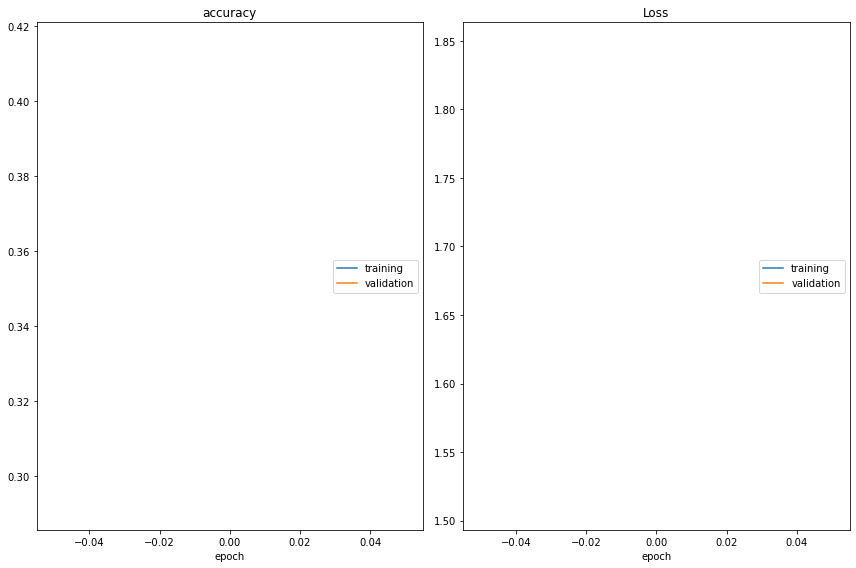

accuracy
	training         	 (min:    0.292, max:    0.292, cur:    0.292)
	validation       	 (min:    0.415, max:    0.415, cur:    0.415)
Loss
	training         	 (min:    1.847, max:    1.847, cur:    1.847)
	validation       	 (min:    1.510, max:    1.510, cur:    1.510)

Epoch 00001: saving model to model_weights.h5
448/448 [==============================] - 585s 1s/step - loss: 1.8467 - accuracy: 0.2917 - val_loss: 1.5101 - val_accuracy: 0.4149 - lr: 5.0000e-04
Wall time: 9min 44s


In [7]:
%%time

epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_step = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2, min_lr= 0.00001, mode='auto')

checkpoint = ModelCheckpoint("model_weights.h5", monitor= 'val_accuracy' ,save_weights_only= True,mode='max',verbose =1)
callbacks = [PlotLossesCallback(), checkpoint ,reduce_lr ]

history = model.fit(x=train_generator, steps_per_epoch= steps_per_epoch, 
                    validation_data= validation_generator, validation_steps= validation_step,
                               callbacks= callbacks)

In [8]:
model_json = model.to_json()
model.save_weights("model_weights.h5")
with open("model.json","w") as json_file:
    json_file.write(model_json)